In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

In [5]:
base_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/'
group = glob.glob(base_dir+'/*tiff')
print(len(group))

17


In [314]:
# img = tiff_imread(sorted(group)[13])
# for i in range(4):
#     plot_3d_projections(img[i])

Load base config

In [496]:
cfg = OmegaConf.load('../config/train.yaml')

Make dataset specific changes

In [497]:
cfg.output.project = 'CL_dlg1'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + 'datasets/CodFish/raw_data_for_codetection/*p1*.tiff'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [21,21,21]
cfg.PSF.gauss_radii = [2.,1.,1.]

cfg.evaluation.img_ind = 0
cfg.evaluation.crop_sl = 's_[:,:,100:200,0:100]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 2
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.001

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.bg_estimation.fractal.res = [3,6,6]

cfg.run_name ='CL_dlg1_ch0_f1'
cfg.data_path.sm_fish_ch = 0
cfg.noise.theta = float(100.)
cfg.microscope.scale = 3500
cfg.bg_estimation.fractal.persistence = 0.75
cfg.bg_estimation.fractal.scale = 3500

# cfg.run_name ='CL_dlg1_ch1_f1'
# cfg.data_path.sm_fish_ch = 1
# cfg.noise.theta = float(50.)
# cfg.microscope.scale = 2000
# cfg.bg_estimation.fractal.persistence = 0.5
# cfg.bg_estimation.fractal.scale = 2000

In [498]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'CL_dlg1_ch0_f1'

We load the image and use a simple heuristic function to estimate the noise scale. Here we use the 99% lowest intensity values
to exlude the majority of the signal. Set the percentile value to obtain a range like below. If it is to high (e.g. 99.9 in this example) you will see a long tail with high intensities, if it is to low, e.g. 95 you will get something that looks like a truncated Gaussian.

In [477]:
# export
import scipy.stats as stats  
def estimate_noise_scale(img, bg_est, percentile=99, plot=True, floc=0):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual > np.percentile(residual, percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=floc)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

41.384136419332485


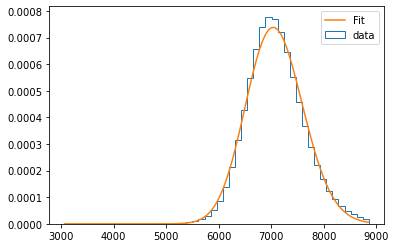

In [471]:
for i in range(1):
    img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[i])[cfg.data_path.sm_fish_ch][None]
    bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img)
    theta = estimate_noise_scale(img, bg_est, percentile=99, floc = 0)
    print(theta)

In [441]:
sorted(glob.glob(cfg.data_path.image_path))

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s3l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s3r.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s4l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s4r.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s5l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s5r.ome.tiff']

Here we plot maximum intensity projections of the whole volume and the sub volume given by evaluation.crop_sl.  
The localizations for this sub volume are tracked during training to evaluate progress. You should chose an interesting (e.g. dense) region.

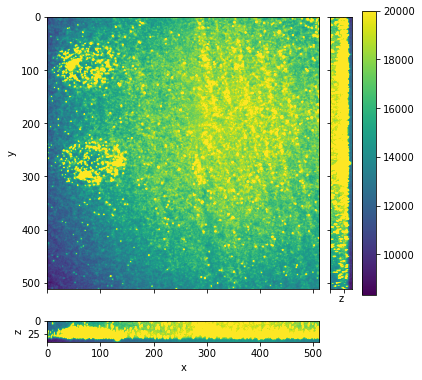

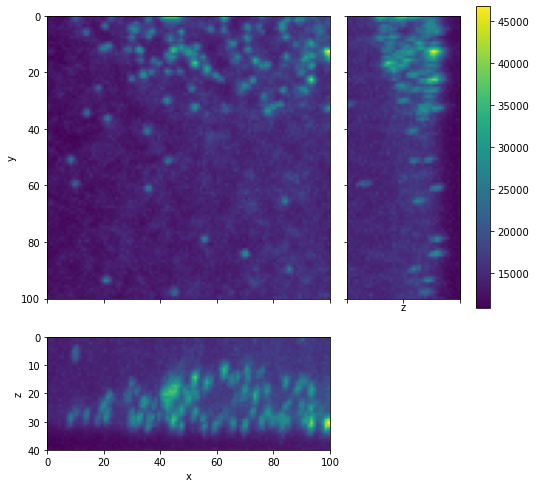

In [442]:
eval_img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[1])[cfg.data_path.sm_fish_ch][None]
_ = plot_3d_projections(eval_img, size=5, proj_func=np.max, vmax=20000)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(eval_img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [443]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (38, 48, 48)
6 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

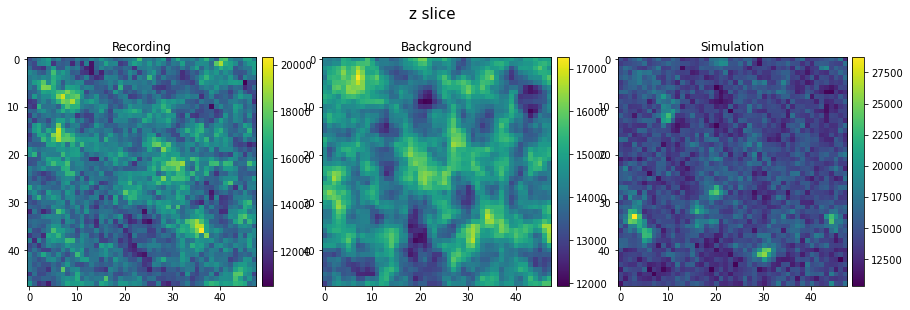

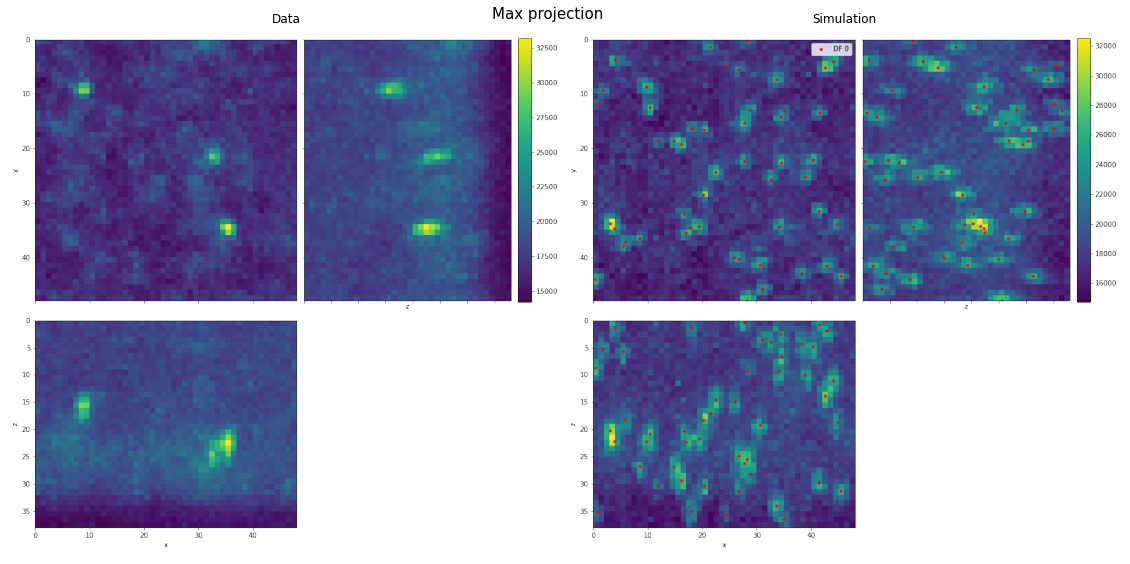

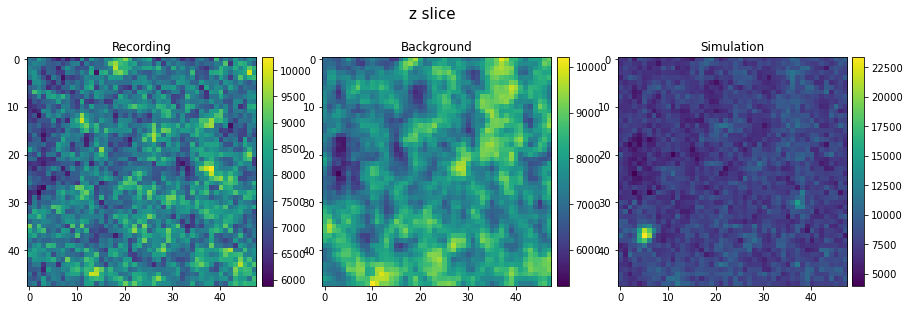

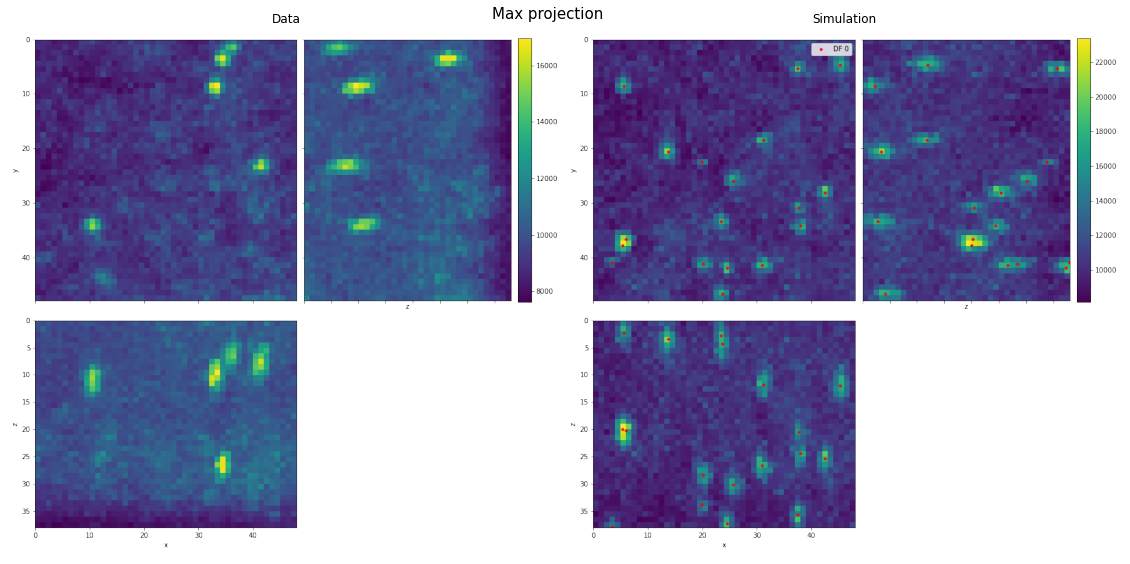

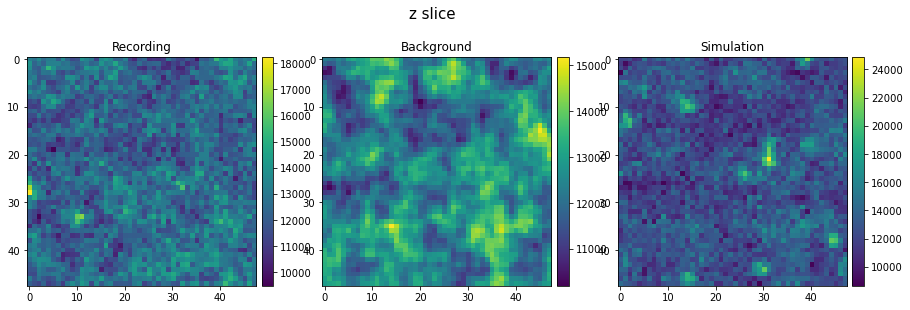

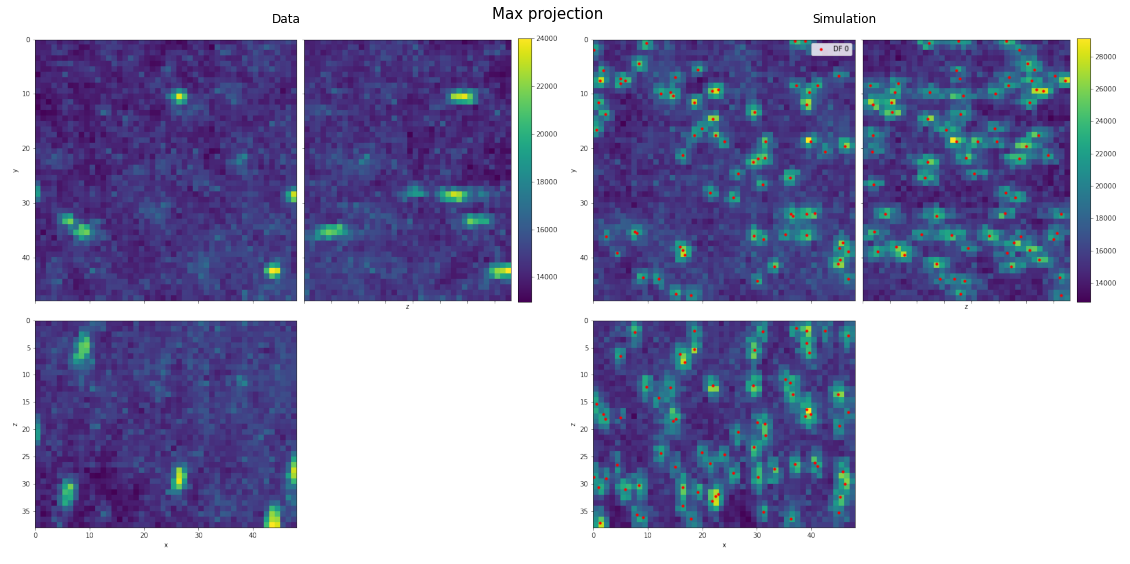

In [447]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3)

Store the config as an experiment

In [14]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'CL_dlg1_f2_ch0'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training for more iterations you could execute:  
"python decode_fish/train.py +experiment=msp300_1 training.num_iters=50000 run_name=long_run"


Command to train a model on the gpu cluster

In [232]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=CL_dlg1_ch1_f1n'

# Evaluation

In [3]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/CL_dlg1/sep_models_ch0_2/image_path:/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/*p1*.tiff/train.yaml')

In [4]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/lib/python3.9/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Crop size larger than volume in at least one dimension. Crop size changed to (38, 48, 48)
6 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(10.0004, device='cuda:0', grad_fn=<DivBackward0>), tensor(9.9999, device='cuda:0', grad_fn=<DivBackward0>), tensor(9.9999, device='cuda:0', grad_fn=<DivBackward0>))


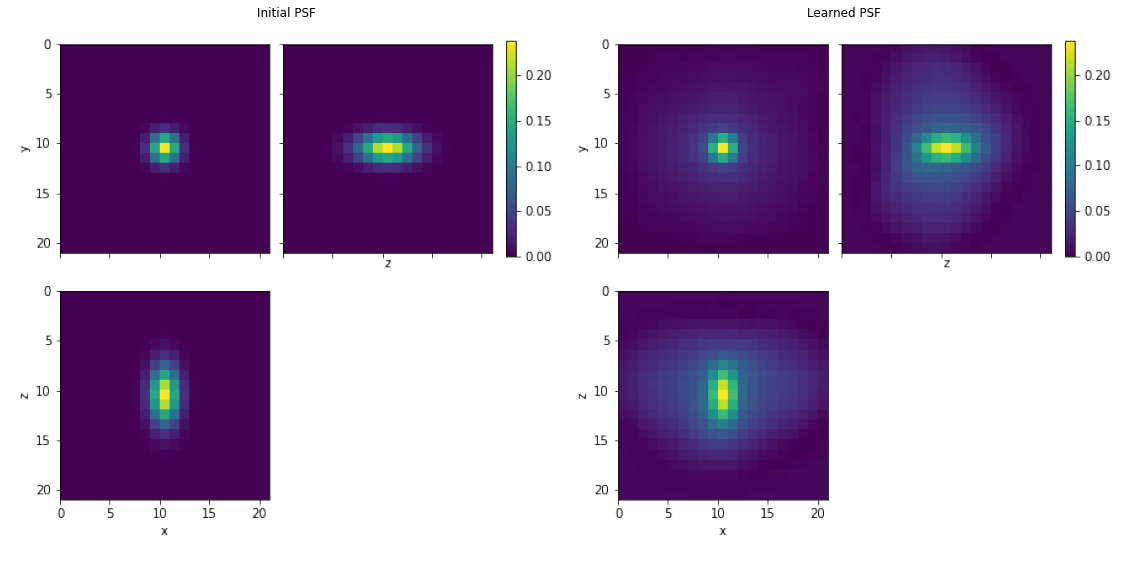

In [5]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

In [7]:
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (38, 48, 48)
6 volumes


Recall: 0.968
Precision: 0.912
Jaccard: 88.482
RMSE_vol: 28.216
Eff_3d: 81.787
FN: 33.0 FP: 96.0
Num. matches: 991.000
Shift: 2.04,-1.58,-4.71


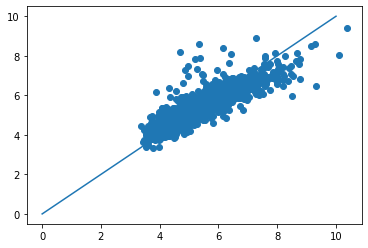

In [8]:
from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 10, micro, model)
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

plt.scatter(matches['int_tar'], matches['int_pred'])
plt.plot([0,10],[0,10])

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

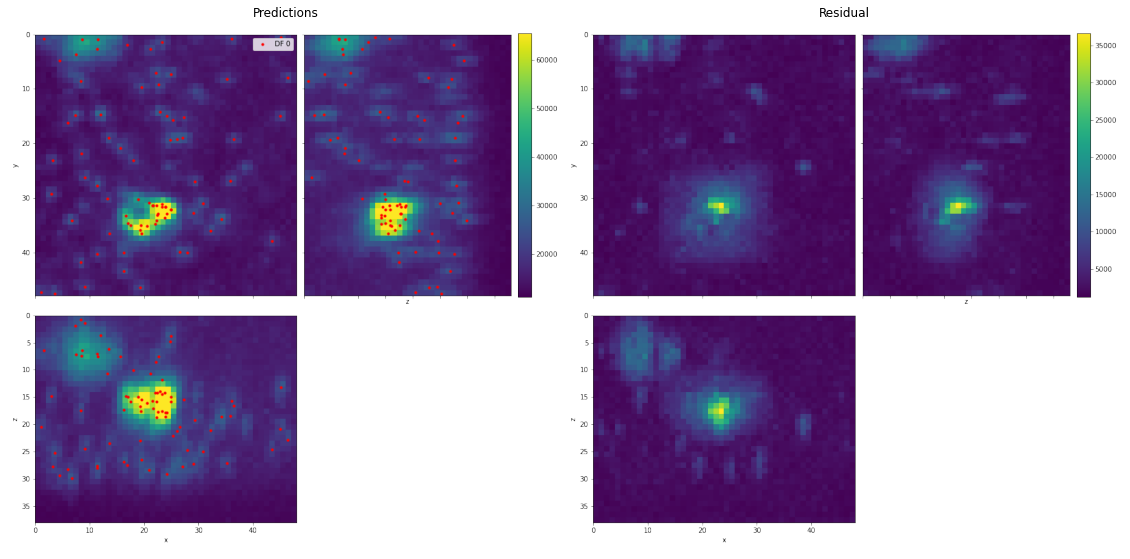

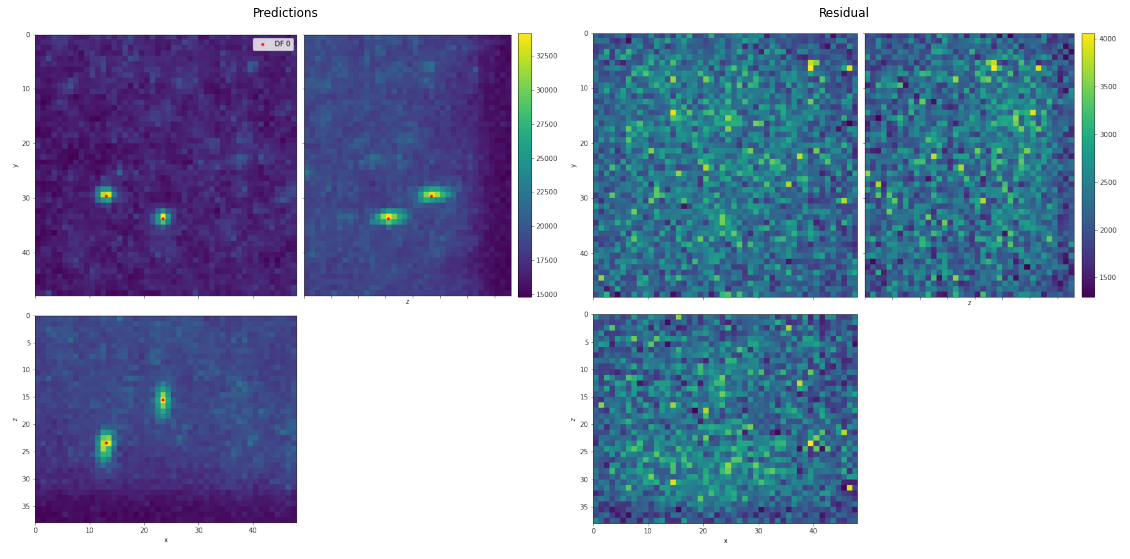

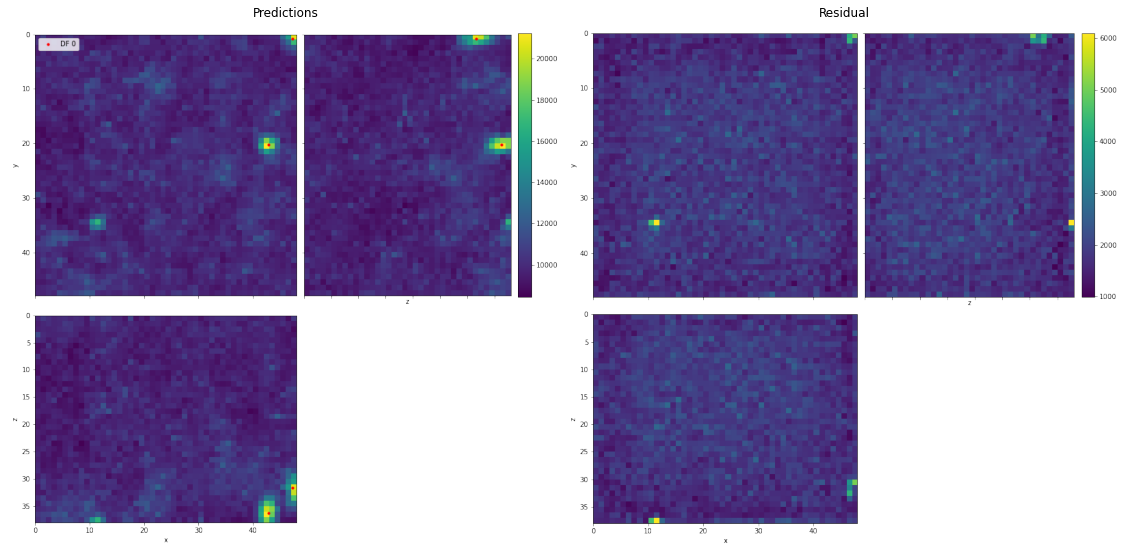

In [462]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=3)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [297]:
# Chose paths of the tif files you wan't to process
image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path))))
# image_paths

In [468]:
cfg.data_path.image_path

'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/*p1*.tiff'

In order to run our network on arbitrarily large volumes we use a sliding window approach.  
Be aware that all leading dimensions (i.e. different channels) get flattened and treated as seperate 'frames'  
**Warning: This method might show inconsistent behavior depending on the window size and sometimes outputs extremely large numbers of localizations. Needs further testing**

In [299]:
pred_df = predict(model, post_proc, image_paths, cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda')

  0%|                                                                        | 0/17 [00:00<?, ?it/s]

20170326_dlgYFP_YFPATTO647N_dlg570_p1s3l.ome.tiff
torch.Size([1, 1, 38, 512, 512])


  6%|███▊                                                            | 1/17 [00:03<00:55,  3.48s/it]

N. emitters:  1003
20170326_dlgYFP_YFPATTO647N_dlg570_p1s3r.ome.tiff
torch.Size([1, 1, 40, 512, 512])


 12%|███████▌                                                        | 2/17 [00:07<00:53,  3.60s/it]

N. emitters:  1513
20170326_dlgYFP_YFPATTO647N_dlg570_p1s4l.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 18%|███████████▎                                                    | 3/17 [00:12<01:02,  4.43s/it]

N. emitters:  1238
20170326_dlgYFP_YFPATTO647N_dlg570_p1s4r.ome.tiff
torch.Size([1, 1, 58, 512, 512])
N. emitters:  1366


 24%|███████████████                                                 | 4/17 [00:18<01:07,  5.20s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p1s5l.ome.tiff
torch.Size([1, 1, 111, 512, 512])
N. emitters:  2132


 29%|██████████████████▊                                             | 5/17 [00:30<01:31,  7.65s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p1s5r.ome.tiff
torch.Size([1, 1, 40, 512, 512])


 35%|██████████████████████▌                                         | 6/17 [00:34<01:09,  6.35s/it]

N. emitters:  1884
20170326_dlgYFP_YFPATTO647N_dlg570_p2s3l.ome.tiff
torch.Size([1, 1, 52, 512, 512])
N. emitters:  783


 41%|██████████████████████████▎                                     | 7/17 [00:40<01:00,  6.07s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p2s3r.ome.tiff
torch.Size([1, 1, 35, 512, 512])


 47%|██████████████████████████████                                  | 8/17 [00:43<00:46,  5.16s/it]

N. emitters:  432
20170326_dlgYFP_YFPATTO647N_dlg570_p2s4r.ome.tiff
torch.Size([1, 1, 66, 512, 512])
N. emitters:  486


 53%|█████████████████████████████████▉                              | 9/17 [00:50<00:45,  5.72s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p2s5l.ome.tiff
torch.Size([1, 1, 49, 512, 512])
N. emitters:  817


 59%|█████████████████████████████████████                          | 10/17 [00:55<00:37,  5.37s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p2s5r.ome.tiff
torch.Size([1, 1, 31, 512, 512])


 65%|████████████████████████████████████████▊                      | 11/17 [00:57<00:27,  4.63s/it]

N. emitters:  483
20170326_dlgYFP_YFPATTO647N_dlg570_p3s3l.ome.tiff
torch.Size([1, 1, 48, 512, 512])
N. emitters:  4237


 71%|████████████████████████████████████████████▍                  | 12/17 [01:02<00:23,  4.61s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p3s3r.ome.tiff
torch.Size([1, 1, 53, 512, 512])


 76%|████████████████████████████████████████████████▏              | 13/17 [01:07<00:18,  4.72s/it]

N. emitters:  3987
20170326_dlgYFP_YFPATTO647N_dlg570_p3s4l.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 82%|███████████████████████████████████████████████████▉           | 14/17 [01:12<00:14,  4.84s/it]

N. emitters:  3361
20170326_dlgYFP_YFPATTO647N_dlg570_p3s4r.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 88%|███████████████████████████████████████████████████████▌       | 15/17 [01:18<00:10,  5.00s/it]

N. emitters:  2607
20170326_dlgYFP_YFPATTO647N_dlg570_p3s5l.ome.tiff
torch.Size([1, 1, 66, 512, 512])
N. emitters:  3721


 94%|███████████████████████████████████████████████████████████▎   | 16/17 [01:24<00:05,  5.43s/it]

20170326_dlgYFP_YFPATTO647N_dlg570_p3s5r.ome.tiff
torch.Size([1, 1, 42, 512, 512])
N. emitters:  2114


100%|███████████████████████████████████████████████████████████████| 17/17 [01:28<00:00,  5.20s/it]


In [302]:
pred_1 = pred_df

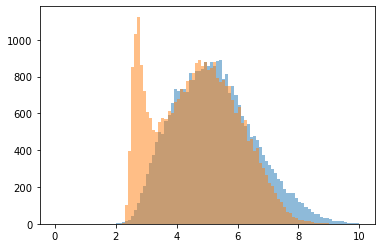

In [303]:
_=plt.hist(pred_0['int'], alpha=0.5, bins=np.linspace(0,10,101))
_=plt.hist(pred_1['int'], alpha=0.5, bins=np.linspace(0,10,101))

In [281]:
from decode_fish.funcs.matching import matching
perf_df, matches, shift = matching(pred_0[pred_0['frame_idx']<11], pred_1[pred_1['frame_idx']<11], print_res=True)

100%|███████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.38s/it]

Recall: 0.759
Precision: 0.595
Jaccard: 50.093
RMSE_vol: 190.902
Eff_3d: -7.711
FN: 2397.0 FP: 5136.0
Shift: 64.15,-32.85,153.73


In [240]:
!nvidia-smi

Fri Jun 25 05:26:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVS 510             Off  | 00000000:02:00.0 N/A |                  N/A |
| 28%   39C    P8    N/A /  N/A |     74MiB /  1998MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 42%   

In [283]:
pred_1_corr = shift_df(pred_1, [64.14,-26.86,135.58])
# pred_1_corr = pred_1_corr[pred_1_corr['comb_sig']<0.4]

In [243]:
!kill 25549 

In [282]:
from decode_fish.funcs.matching import matching
perf_df, matches, shift = matching(pred_0, pred_1, print_res=True)

100%|███████████████████████████████████████████████████████████████| 17/17 [06:58<00:00, 24.65s/it]

Recall: 0.839
Precision: 0.744
Jaccard: 65.120
RMSE_vol: 176.675
Eff_3d: 5.026
FN: 4740.0 FP: 8489.0
Shift: 64.14,-26.86,135.58


In [284]:
perf_df, matches, shift = matching(pred_0, pred_1_corr, print_res=True)

100%|███████████████████████████████████████████████████████████████| 17/17 [07:09<00:00, 25.25s/it]

Recall: 0.843
Precision: 0.748
Jaccard: 65.644
RMSE_vol: 82.324
Eff_3d: 46.384
FN: 4620.0 FP: 8369.0
Shift: 2.37,-1.85,6.53


In [261]:
perf_df, matches, shift = matching(pred_0, pred_1_corr, print_res=True)

100%|███████████████████████████████████████████████████████████████| 17/17 [06:37<00:00, 23.38s/it]

Recall: 0.845
Precision: 0.768
Jaccard: 67.261
RMSE_vol: 83.207
Eff_3d: 47.059
FN: 4538.0 FP: 7478.0
Shift: 8.36,-0.77,20.63


In [309]:
DF(perf_dicts_dec)

NameError: name 'perf_dicts_dec' is not defined

In [304]:
len(pred_0), len(pred_1)

(29438, 32164)

In [211]:
def get_match_rmses(match_df):
    rmses = (match_df['x_tar'] - match_df['x_pred'])**2 
    rmses += (match_df['y_tar'] - match_df['y_pred'])**2
    rmses += (match_df['z_tar'] - match_df['z_pred'])**2
    rmses /= 3
    return np.sqrt(rmses)

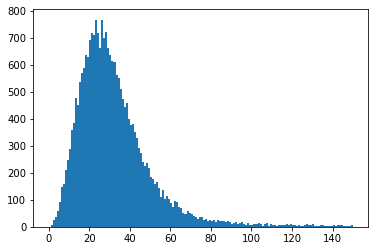

In [212]:
rmses = get_match_rmses(matches)
_ = plt.hist(rmses, bins = np.linspace(0,150,151))

In [ ]:
perf_df, matches, _ = matching(pred_0, pred_1, print_res=True)

Alternatively you can run the prediction on the CPU which is a bit slower

In [269]:
# with torch.no_grad():
#     model.cpu()
#     res = model.tensor_to_dict(model(img_3d[0][None,None]))
#     pred_df = post_proc.get_df(res)
#     free_mem()

The results provided as panda DataFrames which allow for easy indexing and saving/loading.

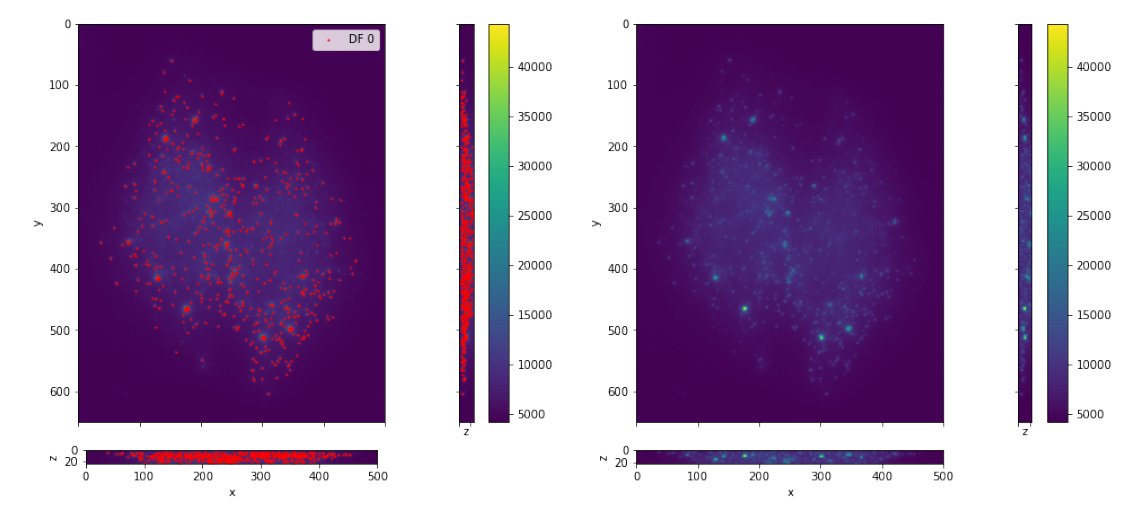

In [237]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds = pred_df[pred_df['frame_idx'] == ind]
preds_px = nm_to_px(preds, px_size_zyx=cfg.evaluation.px_size_zyx)
fig1, axes = plot_3d_projections(img, display=False)
scat_3d_projections(axes, preds_px, s_fac=0.1)
fig2, axes = plot_3d_projections(img, display=False)
_ = combine_figures([fig1,fig2],[], figsize=(20,10))

In [278]:
# Save as csv
pred_df.to_csv('../data/results/CL_dlg1_ch1.csv', index=False)
# Load from csv
# pred_df = pd.read_csv('../data/results/CL_dlg1_ch0.csv')

You can also perform the prediction with the predict.py script. Just provide the model path, the image path string, and the name for the output file.

In [13]:
# !python decode_fish/predict.py out_file='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/msp300_predictions.csv' \
# model_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/msp300_smFISH/nb_run/msp300_1/model.pkl' \
# image_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300*.tif'

In [ ]:
# pred_df = pd.read_csv('msp300_predictions.csv')

In [517]:
import tifffile
for f in sorted(glob.glob('/groups/turaga/home/speisera/share_TUM/coloc_data/titlow/*tiff')):
    
    img = load_tiff_image(f)
    tifffile.imwrite(f.replace('.ome.tiff', '_ch0.tif'), data=img[0].numpy())
    tifffile.imwrite(f.replace('.ome.tiff', '_ch1.tif'), data=img[1].numpy())

In [518]:
from PIL import Image
from PIL.TiffTags import TAGS

with Image.open(f) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.iterkeys()}

AttributeError: 'ImageFileDirectory_v1' object has no attribute 'iterkeys'

In [519]:
f

'/groups/turaga/home/speisera/share_TUM/coloc_data/titlow/20170326_dlgYFP_YFPATTO647N_dlg570_p3s5r.ome.tiff'

In [522]:
import exifread
# Open image file for reading (binary mode)
f = open(f, 'rb')

# Return Exif tags
tags = exifread.process_file(f)

# Print the tag/ value pairs
# for tag in tags.keys():
#     if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
#         print "Key: %s, value %s" % (tag, tags[tag])

ModuleNotFoundError: No module named 'exifread'

In [530]:
with tifffile.TiffFile('/groups/turaga/home/speisera/share_TUM/coloc_data/titlow/20170326_dlgYFP_YFPATTO647N_dlg570_p3s5r.ome.tiff') as tif:
    imagej_hyperstack = tif.asarray()
#     print(dir(tif))
    print(tif.ome_metadata)

</OME>


In [527]:
imagej_metadata